# Word2Vec

This lesson is designed to explore features of word embeddings produced through the word2vec model.

The primary corpus we use consists of the <a href="http://txtlab.org/?p=601">150 English-language novels</a> made available by the <em>.txtLab</em> at McGill University. We also look at a <a href="http://ryanheuser.org/word-vectors-1/">Word2Vec model trained on the ECCO-TCP corpus</a> of 2,350 eighteenth-century literary texts made available by Ryan Heuser. (Note that I have shortened the number of terms in the model by half in order to conserve memory.)

For further background on Word2Vec's mechanics, I suggest this <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

### Workshop Agenda
<ol>
<li>Import & Pre-Processing</li>
<li>Word2Vec</li>
<ol><li>Training</li>
<li>Embeddings</li>
<li>Visualization</li>
</ol>
<li>Saving/Loading Models</li>
</ol>

# 0. Prep

### Visualization parameters

In [1]:
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


### Import Packages

In [2]:
# Data Wrangling

import os
import numpy as np
import pandas
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

In [3]:
# Natural Language Processing

import gensim
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
# Custom Tokenizer for Classroom Use

def fast_tokenize(text):
    
    # Get a list of punctuation marks
    from string import punctuation
    
    lower_case = text.lower()
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in lower_case if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

# 1. Import & Pre-Processing

### Corpus Description
English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts reside on disk, each in a separate plaintext file. Metadata is contained in a spreadsheet distributed with the novel files.

### Metadata Columns
<ol><li>Filename: Name of file on disk</li>
<li>ID: Unique ID in Piper corpus</li>
<li>Language: Language of novel</li>
<li>Date: Initial publication date</li>
<li>Title: Title of novel</li>
<li>Gender: Authorial gender</li>
<li>Person: Textual perspective</li>
<li>Length: Number of tokens in novel</li></ol>

## Import Metadata

In [5]:
# Import Metadata into Pandas Dataframe

meta_df = pandas.read_csv('resources/txtlab_Novel450_English.csv')

In [ ]:
# Check Metadata

meta_df

## Import Corpus

In [7]:
# Set location of corpus folder

fiction_folder = 'txtlab_Novel450_English/'

In [8]:
# Collect the text of each file in the 'fiction_folder' on the hard drive

# Create empty list, each entry will be the string for a given novel
novel_list = []

# Iterate through filenames in 'fiction_folder'
for filename in os.listdir(fiction_folder):
    
    # Read novel text as single string
    with open(fiction_folder + filename, 'r') as file_in:
        this_novel = file_in.read()
    
    # Add novel text as single string to master list
    novel_list.append(this_novel)

In [ ]:
# Inspect first item in novel_list

novel_list[0]

## Pre-Processing
Word2Vec learns about the relationships among words by observing them in context. This means that we want to split our texts into word-units. However, we  want to maintain sentence boundaries as well, since the last word of the previous sentence might skew the meaning of the next sentence.

Since novels were imported as single strings, we'll first use <i>sent_tokenize</i> to divide them into sentences, and second, we'll split each sentence into its own list of words.

In [10]:
# Split each novel into sentences

sentences = [sentence for novel in novel_list for sentence in sent_tokenize(novel)]

In [11]:
# Inspect first sentence

sentences[0]

'\n\n\nAUTHOR’S INTRODUCTION\n\n\n\nMy dog had made a point on a piece of fallow-ground, and led the curate and me two or three hundred yards over that and some stubble adjoining, in a breathless state of expectation, on a burning first of September.'

In [12]:
# Split each sentence into tokens

words_by_sentence = [fast_tokenize(sentence) for sentence in sentences]

In [13]:
# Remove any sentences that contain zero tokens

words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

In [14]:
# Inspect first sentence

words_by_sentence[0]

['author’s',
 'introduction',
 'my',
 'dog',
 'had',
 'made',
 'a',
 'point',
 'on',
 'a',
 'piece',
 'of',
 'fallowground',
 'and',
 'led',
 'the',
 'curate',
 'and',
 'me',
 'two',
 'or',
 'three',
 'hundred',
 'yards',
 'over',
 'that',
 'and',
 'some',
 'stubble',
 'adjoining',
 'in',
 'a',
 'breathless',
 'state',
 'of',
 'expectation',
 'on',
 'a',
 'burning',
 'first',
 'of',
 'september']

# 2. Word2Vec

### Word Embedding
Word2Vec is the most prominent word embedding algorithm. Word embedding generally attempts to identify semantic relationships between words by observing them in context.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
</ul>

Note: Script uses default value for each argument

## Training

In [15]:
# Train word2vec model from txtLab corpus

model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=25, sg=1, alpha=0.025, iter=5, batch_words=10000)

## Embeddings

In [16]:
# Return dense word vector

model['whale']

array([ -8.22380126e-01,   1.64342880e-01,   9.55340788e-02,
         3.25816035e-01,  -1.52457133e-01,  -7.03769088e-01,
        -7.62226060e-02,   9.71872747e-01,   2.40129739e-01,
         3.08740556e-01,  -1.29433721e-01,   1.35417968e-01,
         1.39258727e-01,   2.32932597e-01,  -1.97724149e-01,
         2.33005300e-01,  -4.41207528e-01,  -6.51600212e-02,
        -5.09922206e-01,  -2.48481080e-01,   7.45409429e-02,
        -3.15204784e-02,  -1.86982036e-01,   2.79949278e-01,
         2.30206251e-02,   4.73515987e-01,   1.29174767e-02,
         1.47057801e-01,  -1.59653604e-01,   1.33631795e-04,
         1.91302225e-02,   1.10629098e-02,  -4.63729680e-01,
         1.05601847e-01,   6.20203614e-01,   7.86738619e-02,
         2.96308845e-01,  -1.27077356e-01,  -8.14963281e-02,
        -4.58102524e-01,  -4.40038353e-01,   7.93931857e-02,
        -2.16367245e-02,  -2.50366539e-01,   1.59759551e-01,
        -2.44383082e-01,   3.73668045e-01,   4.19167638e-01,
         4.20523345e-01,

## Vector-Space Operations

### Similarity
Since words are represented as dense vectors, we can ask how similiar words' meanings are based on their cosine similarity (essentially how much they overlap). <em>gensim</em> has a few dout-of-the-box functions that enable different kinds of comparisons.

In [17]:
# Find cosine distance between two given word vectors

model.similarity('pride','prejudice')

0.57363124389445053

In [18]:
# Find nearest word vectors by cosine distance

model.most_similar('pride')

[('arrogance', 0.7091377973556519),
 ('vanity', 0.6972477436065674),
 ('egotism', 0.677453875541687),
 ('conceit', 0.6751539707183838),
 ('selfishness', 0.6717022657394409),
 ('resentment', 0.6698406934738159),
 ('audacity', 0.6691268682479858),
 ('anger', 0.6688488125801086),
 ('heroism', 0.6673762202262878),
 ('selfconceit', 0.6655232906341553)]

In [19]:
# Given a list of words, we can ask which doesn't belong

# Finds mean vector of words in list
# and identifies the word further from that mean

model.doesnt_match(['pride','prejudice', 'whale'])

'whale'

### Multiple Valences
A word embedding may encode both primary and secondary meanings that are both present at the same time. In order to identify secondary meanings in a word, we can subtract the vectors of primary (or simply unwanted) meanings. For example, we may wish to remove the sense of <em>river bank</em> from the word <em>bank</em>. This would be written mathetmatically as <em>RIVER - BANK</em>, which in <em>gensim</em>'s interface lists <em>RIVER</em> as a positive meaning and <em>BANK</em> as a negative one.

In [20]:
# Get most similar words to BANK, in order
# to get a sense for its primary meaning

model.most_similar('bank')

[('illinois', 0.6837126016616821),
 ('creek', 0.6828964352607727),
 ('thames', 0.6776638031005859),
 ('river', 0.6772173643112183),
 ('flats', 0.6703978776931763),
 ('cove', 0.6631561517715454),
 ('plateau', 0.6596856117248535),
 ('footpath', 0.6588583588600159),
 ('girard', 0.6564387083053589),
 ('shore', 0.6536604166030884)]

In [21]:
# Remove the sense of "river bank" from "bank" and see what is left

model.most_similar(positive=['bank'], negative=['river'])

[('testaments', 0.3998016119003296),
 ('treasury', 0.36606645584106445),
 ('cheques', 0.36304059624671936),
 ('disposing', 0.34858405590057373),
 ('unpaid', 0.34485700726509094),
 ('memorandum', 0.3445650339126587),
 ('treasurer', 0.3430730104446411),
 ('clerk', 0.3391572833061218),
 ('office', 0.3349580764770508),
 ('angloindian', 0.33339357376098633)]

### Analogy
Analogies are rendered as simple mathematical operations in vector space. For example, the canonic word2vec analogy <em>MAN is to KING as WOMAN is to ??</em> is rendered as <em>KING - MAN + WOMAN</em>. In the gensim interface, we designate <em>KING</em> and <em>WOMAN</em> as positive terms and <em>MAN</em> as a negative term, since it is subtracted from those.

In [22]:
# Get most similar words to KING, in order
# to get a sense for its primary meaning

model.most_similar('king')

[('duke', 0.7815576195716858),
 ('kings', 0.7415188550949097),
 ('minister', 0.7375909090042114),
 ('prince', 0.7229074835777283),
 ('emperor', 0.7183017134666443),
 ('otho', 0.7132425308227539),
 ('casimir', 0.7090590596199036),
 ('karl', 0.6967421770095825),
 ('ruritania', 0.6753348112106323),
 ('strelsau', 0.6627833247184753)]

In [23]:
# The canonic word2vec analogy: King - Man + Woman -> Queen

model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7532585263252258),
 ('princess', 0.7063238620758057),
 ('duchess', 0.6486999988555908),
 ('duke', 0.6454578638076782),
 ('virgin', 0.6393348574638367),
 ('emperor', 0.6371687650680542),
 ('ruritania', 0.6258261203765869),
 ('empress', 0.6220406293869019),
 ('priest', 0.6198825836181641),
 ('virgins', 0.6180473566055298)]

### Gendered Vectors
Can we find gender a la Schmidt (2015)? (Note that this method uses vector projection, whereas Schmidt had used rejection.)

In [28]:
# Feminine Vector

model.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'], topn=50)

[('madeline', 0.5467969179153442),
 ('louisa', 0.4959941506385803),
 ('agnes', 0.4918912351131439),
 ('julia', 0.48071807622909546),
 ('berlinton', 0.46668902039527893),
 ('edeliza', 0.4624362885951996),
 ('roseline', 0.45418089628219604),
 ('pauline', 0.45125430822372437),
 ('emma', 0.4494338035583496),
 ('eliza', 0.4467594027519226),
 ('lucy', 0.4450529217720032),
 ('beverley', 0.4447824954986572),
 ('helens', 0.44347715377807617),
 ('virginia', 0.4338955879211426),
 ('anne', 0.43370598554611206),
 ('girlish', 0.4326920211315155),
 ('lovable', 0.43036437034606934),
 ('kilman', 0.4299003481864929),
 ('fragile', 0.42957156896591187),
 ('wharton', 0.42838430404663086),
 ('eugenia', 0.42798495292663574),
 ('bewitching', 0.42683038115501404),
 ('charms', 0.42507481575012207),
 ('niece', 0.4239894151687622),
 ('fanny', 0.4234875440597534),
 ('emmeline', 0.4227035939693451),
 ('valery', 0.41939836740493774),
 ('caroline', 0.4186074733734131),
 ('liddy', 0.41396182775497437),
 ('elizabeth', 

In [25]:
# Masculine Vector

model.most_similar(positive=['he','him','his','himself'], negative=['she','her','hers','herself'])

[('osterman', 0.4396858811378479),
 ('mahbub', 0.40488001704216003),
 ('harran', 0.4001975655555725),
 ('annixter', 0.3985745310783386),
 ('pipe', 0.3956775665283203),
 ('bonneville', 0.39561954140663147),
 ('buck', 0.39459893107414246),
 ('gun', 0.38652318716049194),
 ('clerk', 0.3834838271141052),
 ('railroad', 0.3831042945384979)]

### Exercises

In [ ]:
## EX. Use the most_similar method to find the tokens nearest to 'car' in our model.
##     Do the same for 'motorcar'.

## Q.  What characterizes each word in our corpus? Does this make sense?

In [ ]:
model.most_similar('car')

In [ ]:
model.most_similar('motorcar')

In [ ]:
## EX. How does our model answer the analogy: MADRID is to SPAIN as PARIS is to __________

## Q.  What has our model learned about nation-states?

In [ ]:
model.most_similar(positive=['spain', 'paris'], negative=['madrid'])

In [ ]:
## EX. Perform the canonic Word2Vec addition again but leave out a term:
##     Try 'king' - 'man', 'woman' - 'man', 'woman' + 'king'

## Q.  What do these indicate semantically?

In [29]:
model.most_similar(positive=['king'], negative=['man'])

[('kings', 0.47593989968299866),
 ('royal', 0.45434629917144775),
 ('reign', 0.4513101875782013),
 ('——', 0.44086626172065735),
 ('emperor', 0.4362276792526245),
 ('strelsau', 0.4240732491016388),
 ('coronation', 0.42335575819015503),
 ('saint', 0.42275771498680115),
 ('ruritania', 0.413887619972229),
 ('scots', 0.4065362215042114)]

In [ ]:
model.most_similar(positive=['woman'], negative=['man'])

In [ ]:
model.most_similar(positive=['woman', 'king'])

## Visualization

In [ ]:
# Dictionary of words in model

model.wv.vocab
#model.vocab # deprecated

In [ ]:
# Visualizing the whole vocabulary would make it hard to read

len(model.wv.vocab)
#len(model.vocab) # deprecated

In [30]:
# For interpretability, we'll select words that already have a semantic relation

her_tokens = [token for token,weight in model.most_similar(positive=['she','her','hers','herself'], \
                                                       negative=['he','him','his','himself'], topn=50)]

In [31]:
# Inspect list

her_tokens

['madeline',
 'louisa',
 'agnes',
 'julia',
 'berlinton',
 'edeliza',
 'roseline',
 'pauline',
 'emma',
 'eliza',
 'lucy',
 'beverley',
 'helens',
 'virginia',
 'anne',
 'girlish',
 'lovable',
 'kilman',
 'fragile',
 'wharton',
 'eugenia',
 'bewitching',
 'charms',
 'niece',
 'fanny',
 'emmeline',
 'valery',
 'caroline',
 'liddy',
 'elizabeth',
 'womanly',
 'helen',
 'janes',
 'rosabella',
 'bridal',
 'diana',
 'glorvina',
 'charlotte',
 'olenska',
 'prettiness',
 'camilla',
 'loveliest',
 'feminine',
 'fannys',
 'jane',
 'lovely',
 'flora',
 'mary',
 'indiana',
 'brides']

In [32]:
# Get the vector for each sampled word

vectors = [model[word] for word in her_tokens]  

In [33]:
# Calculate distances among texts in vector space

dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')

In [34]:
# Multi-Dimensional Scaling (Project vectors into 2-D)

mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

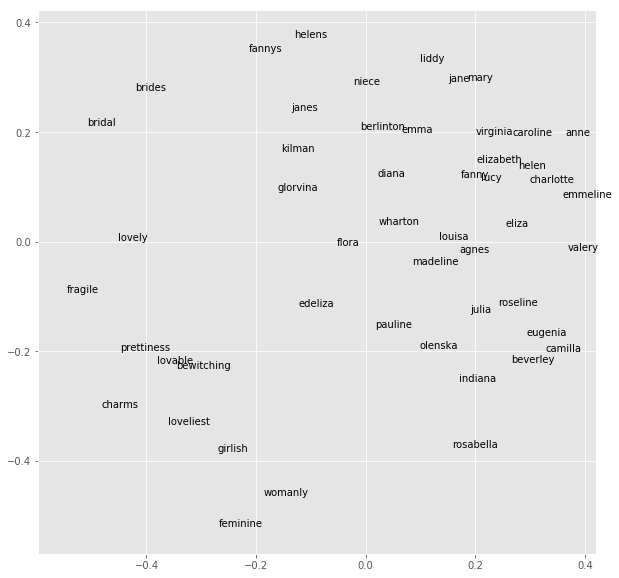

In [35]:
# Fussing with matplotlib

_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))

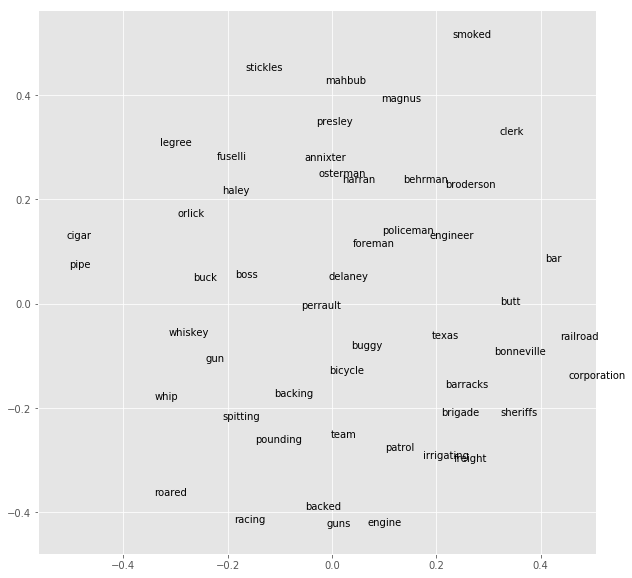

In [36]:
# For comparison, here is the same graph using a masculine-pronoun vector

his_tokens = [token for token,weight in model.most_similar(positive=['he','him','his','himself'], \
                                                       negative=['she','her','hers','herself'], topn=50)]
vectors = [model[word] for word in his_tokens]
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(his_tokens[i], ((embeddings[i,0], embeddings[i,1])))

In [ ]:
## Q. What kinds of semantic relationships exist in the diagram above?
##    Are there any words that seem out of place?

<img src="resources/fem_vectors.png", width="50%",style="float: left;" /><img src="resources/masc_vectors.png", width="50%" />

# 3. Saving/Loading Models

In [37]:
# Save current model for later use

model.wv.save_word2vec_format('resources/word2vec.txtlab_Novel150_English.txt')
#model.save_word2vec_format('resources/word2vec.txtlab_Novel150_English.txt') # deprecated

In [38]:
# Load up models from disk

# Model trained on Eighteenth Century Collections Online corpus (~2500 texts)
# Made available by Ryan Heuser: http://ryanheuser.org/word-vectors-1/

ecco_model = gensim.models.KeyedVectors.load_word2vec_format('resources/word2vec.ECCO-TCP.txt')
#ecco_model = gensim.models.Word2Vec.load_word2vec_format('resources/word2vec.ECCO-TCP.txt') # deprecated

In [39]:
# What are similar words to BANK?

ecco_model.most_similar('bank')

[('ground', 0.6570006608963013),
 ('turf', 0.6564096808433533),
 ('surface', 0.6480724215507507),
 ('declivity', 0.642420768737793),
 ('hill', 0.637111485004425),
 ('bridge', 0.6332241296768188),
 ('terrace', 0.630118727684021),
 ('channel', 0.6295770406723022),
 ('banks', 0.6294738054275513),
 ('wall', 0.6289103031158447)]

In [40]:
# What if we remove the sense of "river bank"?

ecco_model.most_similar(positive=['bank'], negative=['river'])

[('currency', 0.36714258790016174),
 ('suit', 0.35922902822494507),
 ('stamp', 0.3582037687301636),
 ('promissory', 0.35605305433273315),
 ('pension', 0.35183221101760864),
 ('blank', 0.3518177270889282),
 ('payable', 0.34270501136779785),
 ('mortality', 0.34262460470199585),
 ('weekly', 0.3408060669898987),
 ('weal', 0.3309360146522522)]

### Exercise

In [ ]:
## EX. Heuser's blog post explores an analogy in eighteenth-century thought that
##     RICHES are to VIRTUE what LEARNING is to GENIUS. How true is this in
##     the ECCO-trained Word2Vec model? Is it true in the one we trained?

##  Q. How might we compare word2vec models more generally?

In [41]:
# ECCO model: RICHES are to VIRTUE what LEARNING is to ??

ecco_model.most_similar(positive=['virtue', 'learning'], negative=['riches'])

[('piety', 0.7372760772705078),
 ('morality', 0.7266901135444641),
 ('science', 0.6974709630012512),
 ('prudence', 0.6855394840240479),
 ('philosophy', 0.6830791234970093),
 ('wisdom', 0.6511392593383789),
 ('genius', 0.6505820751190186),
 ('humanity', 0.640283465385437),
 ('modesty', 0.6369402408599854),
 ('morals', 0.6340599060058594)]

In [42]:
# txtLab model: RICHES are to VIRTUE what LEARNING is to ??

model.most_similar(positive=['virtue', 'learning'], negative=['riches'])

[('teaching', 0.6101517081260681),
 ('believer', 0.5892437696456909),
 ('philosophy', 0.5841563940048218),
 ('poetry', 0.5647507905960083),
 ('science', 0.5621806383132935),
 ('principle', 0.5602642893791199),
 ('epic', 0.5583522319793701),
 ('purely', 0.5536725521087646),
 ('practising', 0.5521074533462524),
 ('wisdom', 0.5479782819747925)]

# 4. Open Questions
At this point, we have seen a number of mathemetical operations that we may use to explore word2vec's word embeddings. These enable us to answer a set of new, interesting questions dealing with semantics, yet there are many other questions that remain unanswered.

For example:
<ol>
<li>How to compare word usages in different texts (within the same model)?</li>
<li>How to compare word meanings in different models? compare whole models?</li>
<li>What about the space “in between” words?</li>
<li>Do we agree with the Distributional Hypothesis that words with the same contexts share their meanings?</li>
<ol><li>If not, then what information do we think is encoded in a word’s context?</li></ol>
<li>What good, humanistic research questions do analogies shed light on?</li>
<ol><li>shades of meaning?</li><li>context similarity?</li></ol>
</ol>